Final thing, works. don't do anything.

In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 1 · For Reproducibility
# ────────────────────────────────────────────────────────────────
import os, random, numpy as np, torch
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED);  np.random.seed(SEED)
torch.manual_seed(SEED);  torch.cuda.manual_seed_all(SEED)
print("Global RNG seed set to 42")

Global RNG seed set to 42


In [ ]:
# ────────────────────────────────────────────────────────────────
# Download & verify CTD + ChEMBL raw data
# ────────────────────────────────────────────────────────────────
import pathlib, requests, hashlib, tarfile, gzip
from tqdm.auto import tqdm

DATA_DIR = pathlib.Path("data")
DATA_DIR.mkdir(exist_ok=True)

FILES = {
    "CTD_chem_gene_ixns.tsv.gz":
        ("http://ctdbase.org/reports/CTD_chem_gene_ixns.tsv.gz",  None),
    "CTD_chemicals_diseases.tsv.gz":
        ("http://ctdbase.org/reports/CTD_chemicals_diseases.tsv.gz",  None),
    "chembl_35_sqlite.tar.gz":
        ("https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_sqlite.tar.gz",  None),
}

def sha256(path, buf=2**20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(buf), b""):
            h.update(chunk)
    return h.hexdigest()

def download(url, dst):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    bar   = tqdm(total=total, unit="B", unit_scale=True, desc=dst.name)
    with open(dst, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
            bar.update(len(chunk))
    bar.close()

for fname, (url, checksum) in FILES.items():
    path = DATA_DIR / fname
    if path.exists() and checksum and sha256(path) == checksum:
        print(f"✓ {fname} verified – skipping")
        continue
    if not path.exists():
        print(f"↓ downloading {fname}")
        download(url, path)
    if checksum:
        assert sha256(path) == checksum, f"Checksum failed for {fname}"
print("All downloads complete ")

tar_path = DATA_DIR / "chembl_35_sqlite.tar.gz"
extract_dir = DATA_DIR / "chembl_35"
if tar_path.exists() and not extract_dir.exists():
    print(f"⇡ extracting {tar_path.name} …")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(DATA_DIR)
    print("Extraction done ")
else:
    print("ChEMBL archive already extracted or missing.")

for p in sorted(DATA_DIR.rglob("*")):
    print(p.relative_to(DATA_DIR), f"({p.stat().st_size/1e6:,.1f} MB)")

↓ downloading CTD_chem_gene_ixns.tsv.gz


CTD_chem_gene_ixns.tsv.gz:   0%|          | 0.00/39.7M [00:00<?, ?B/s]

↓ downloading CTD_chemicals_diseases.tsv.gz


CTD_chemicals_diseases.tsv.gz:   0%|          | 0.00/154M [00:00<?, ?B/s]

↓ downloading chembl_35_sqlite.tar.gz


chembl_35_sqlite.tar.gz:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

All downloads complete ✅
⇡ extracting chembl_35_sqlite.tar.gz …
Extraction done ✅
CTD_chem_gene_ixns.tsv.gz (39.7 MB)
CTD_chemicals_diseases.tsv.gz (154.0 MB)
chembl_35 (0.0 MB)
chembl_35/chembl_35_sqlite (0.0 MB)
chembl_35/chembl_35_sqlite/INSTALL_sqlite (0.0 MB)
chembl_35/chembl_35_sqlite/chembl_35.db (26,034.3 MB)
chembl_35_sqlite.tar.gz (4,986.5 MB)


In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 3 · Build CTD edge list  +  DotLink predictor  ➜ link_net
# ────────────────────────────────────────────────────────────────
import pandas as pd, pathlib, numpy as np, random, torch, torch.nn as nn
from sklearn.model_selection import train_test_split

CTD_DISEASE = pathlib.Path("data/CTD_chemicals_diseases.tsv.gz")
cols = ["ChemicalName","ChemicalID","CasRN","DiseaseName","DiseaseID",
        "DirectEvidence","InferenceGeneSymbol","InferenceScore","OmimIDs","PubMedIDs"]
df = pd.read_csv(CTD_DISEASE, sep="\t", comment="#", names=cols,
                 dtype=str, usecols=["ChemicalID","DiseaseID"]).dropna().drop_duplicates()

chem2idx = {cid:i for i,cid in enumerate(sorted(df["ChemicalID"].unique()))}
diz2idx  = {did:i for i,did in enumerate(sorted(df["DiseaseID"].unique()))}
pairs    = np.array([[chem2idx[c], diz2idx[d]] for c,d in zip(df["ChemicalID"], df["DiseaseID"])], dtype=np.int32)

train_pos, tmp = train_test_split(pairs, test_size=0.2, random_state=SEED)
val_pos,   test_pos = train_test_split(tmp, test_size=0.5, random_state=SEED)

def sample_neg(n):
    seen = set(map(tuple, pairs)); out=[]
    while len(out)<n:
        c = random.randrange(len(chem2idx)); d = random.randrange(len(diz2idx))
        if (c,d) not in seen: out.append([c,d])
    return np.array(out, np.int32)

train_neg, val_neg, test_neg = map(sample_neg, [len(train_pos), len(val_pos), len(test_pos)])


device = "cuda" if torch.cuda.is_available() else "cpu"
class DotLink(nn.Module):
    def __init__(s,nc,nd,dim=64):
        super().__init__(); s.l = nn.Embedding(nc,dim); s.r = nn.Embedding(nd,dim)
    def forward(s,x): return (s.l(x[:,0])*s.r(x[:,1])).sum(1)

dotlink = DotLink(len(chem2idx), len(diz2idx)).to(device)
opt = torch.optim.Adam(dotlink.parameters(), lr=3e-3)
bce = nn.BCEWithLogitsLoss()

def batch(p,n):
    x = np.vstack([p,n]); y = np.hstack([np.ones(len(p)), np.zeros(len(n))])
    idx = np.random.permutation(len(x))
    return torch.tensor(x[idx],dtype=torch.long,device=device), torch.tensor(y[idx],dtype=torch.float32,device=device)

for ep in range(3):
    xb,yb = batch(train_pos,train_neg)
    opt.zero_grad(); loss=bce(dotlink(xb), yb); loss.backward(); opt.step()
print("DotLink trained (3 epochs)")

link_net = dotlink.eval()

DotLink trained (3 epochs)


In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 4 · Tiny BioBERT demo: fetch PubMed abstracts ➜ embeddings
# ────────────────────────────────────────────────────────────────
!pip -q install xmltodict

import requests, xmltodict, textwrap, torch
from transformers import AutoTokenizer, AutoModel

SEARCH_TERM = "drug repurposing cancer"
MAX_PMIDS   = 3


esearch = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
pmids = requests.get(
    esearch,
    params=dict(db="pubmed", retmode="json", retmax=MAX_PMIDS, term=SEARCH_TERM)
).json()["esearchresult"]["idlist"]
print("Fetched PMIDs:", pmids)

efetch = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
xml = requests.get(
    efetch,
    params=dict(db="pubmed", retmode="xml", id=",".join(pmids))
).text

def extract_abstract_text(article):
    """Return abstract string or None, handling all PubMed formats."""
    ab = article["MedlineCitation"]["Article"].get("Abstract")
    if not ab:
        return None
    payload = ab.get("AbstractText")

    if isinstance(payload, str):
        return payload
    if isinstance(payload, dict):
        return payload.get("#text", "")
    if isinstance(payload, list):
        chunks = []
        for seg in payload:
            if isinstance(seg, str):
                chunks.append(seg)
            elif isinstance(seg, dict):
                chunks.append(seg.get("#text", ""))
        return " ".join(chunks)
    return None

docs = xmltodict.parse(xml)["PubmedArticleSet"]["PubmedArticle"]
if isinstance(docs, dict):
    docs = [docs]

abstracts = [txt for art in docs if (txt := extract_abstract_text(art))]
print(f"\nFetched {len(abstracts)} abstracts:")
for a in abstracts:
    print(textwrap.shorten(a, 120) + " …")

MODEL = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model     = AutoModel.from_pretrained(MODEL, trust_remote_code=True)
model.eval()

embeddings = []
with torch.no_grad():
    for txt in abstracts:
        inp   = tokenizer(txt, return_tensors="pt", truncation=True, max_length=512)
        cls   = model(**inp).last_hidden_state[:, 0].squeeze()
        embeddings.append(cls)
embeddings = torch.stack(embeddings)
print("\nEmbeddings tensor shape:", embeddings.shape)

if embeddings.size(0) >= 2:
    cos = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=0)
    print(f"Cosine similarity between first two abstracts: {cos.item():.3f}")

# ────────────────────────────────────────────────────────────────
# Cell 5 · BioBERT embeddings for later use
# ────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, pathlib, pyarrow.parquet as pq, pyarrow as pa

SAVE_PATH = pathlib.Path("data/pubmed_embeddings.parquet")

df_embed = pd.DataFrame({
    "pmid": pmids,
    "abstract": abstracts,

    "embedding": [emb.cpu().numpy() for emb in embeddings]
})

table = pa.Table.from_pandas(df_embed, preserve_index=False)
pq.write_table(table, SAVE_PATH)

print(f"Saved {len(df_embed)} embeddings ➜ {SAVE_PATH}")

Fetched PMIDs: ['40248220', '40243563', '40243541']

Fetched 3 abstracts:
Atypical teratoid/rhabdoid tumor (AT/RT) is a rare and aggressive tumor of the primary central nervous system [...] …
Cardiovascular disease remains the leading global cause of mortality, largely driven by atherosclerosis, a chronic [...] …
The development of novel therapeutics in neuro-oncology faces significant challenges, often marked by high costs [...] …


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]


Embeddings tensor shape: torch.Size([3, 768])
Cosine similarity between first two abstracts: 0.910
Saved 3 embeddings ➜ data/pubmed_embeddings.parquet


In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 5 · DrugSelectionEnv  (dense reward, uses link_net)
# ────────────────────────────────────────────────────────────────
import gymnasium as gym
from gymnasium import spaces

EMB_DIM = 768

class DrugSelectionEnv(gym.Env):
    metadata = {}
    def __init__(self, disease_id, link_model, K=20):
        super().__init__()
        self.link_model = link_model
        self.device = next(link_model.parameters()).device
        self.d_idx  = diz2idx[disease_id]
        self.pos    = {c for c,d in map(tuple,pairs) if d==self.d_idx}
        self.K      = K
        self.action_space      = spaces.Discrete(K)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(K,EMB_DIM+1), dtype=np.float32)
        pass
    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        cand = set(random.sample(range(len(chem2idx)), self.K))
        if self.pos: cand.pop(); cand.add(random.choice(list(self.pos)))
        self._cand = list(cand)
        obs = np.zeros((self.K, EMB_DIM+1), np.float32)
        return obs, {}
    def step(self, action):
        action = int(action)
        cid = self._cand[action]

        with torch.no_grad():
            score = torch.sigmoid(
                self.link_model(
                    torch.tensor([[cid, self.d_idx]], device=self.device)
                )
            ).item()

        obs        = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)
        reward     = score
        terminated = True
        truncated  = False
        info       = {"chemical_id": cid, "link_score": score}

        return obs, reward, terminated, truncated, info


env = DrugSelectionEnv(next(iter(diz2idx)), link_net)
obs, _ = env.reset()
print("Observation shape:", obs.shape)
_, r, term, _, info = env.step(env.action_space.sample())
print(f"reward {r:.3f}, terminated {term}")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Observation shape: (20, 769)
reward 0.995, terminated True


In [ ]:
def debug_env(env):
    obs, _ = env.reset()
    print("Candidates (indices):", env._cand)
    score_list = [ torch.sigmoid(
        link_net(torch.tensor([[cid, env.d_idx]], device=env.device))
    ).item() for cid in env._cand ]
    print("Link‑predictor scores:", [f"{s:.2f}" for s in score_list])
debug_env(env)

Candidates (indices): [522, 13071, 13200, 17173, 11672, 5273, 13348, 3891, 16819, 2617, 701, 9668, 5078, 13273, 8929, 4325, 6252, 6512, np.int32(17009), 14461]
Link‑predictor scores: ['0.00', '1.00', '0.97', '0.95', '0.66', '0.06', '0.96', '1.00', '0.63', '0.96', '0.00', '0.65', '0.00', '0.08', '0.98', '0.02', '0.00', '0.00', '1.00', '0.00']


In [ ]:
#!pip install stable-baselines3[extra]

In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 5 · DrugSelectionEnv diagnostics
# ────────────────────────────────────────────────────────────────
import gymnasium as gym
from gymnasium import spaces
import numpy as np, random, torch

EMB_DIM = 768

class DrugSelectionEnv(gym.Env):
    metadata = {}
    def __init__(self, disease_id, link_model, K=20):
        super().__init__()
        self.link_model = link_model
        self.device     = next(link_model.parameters()).device
        self.d_idx      = diz2idx[disease_id]
        self.pos        = {c for c,d in map(tuple,pairs) if d==self.d_idx}
        self.K          = K

        self.action_space      = spaces.Discrete(K)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(K, EMB_DIM + 1),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        cand = set(random.sample(range(len(chem2idx)), self.K))
        if self.pos:
            cand.pop()
            cand.add(random.choice(list(self.pos)))
        self._cand = list(cand)
        obs = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)
        print(f"[reset] generated {len(self._cand)} candidates (should be {self.K})")
        return obs, {}

    def step(self, action):
        raw_act = action
        action = int(action)
        print(f"[step] raw action={raw_act} cast→{action}; "
              f"cand_len={len(self._cand)}; K={self.K}")
        if action < 0 or action >= len(self._cand):
            raise IndexError(f"Action {action} out of range for candidates of length {len(self._cand)}")

        cid = self._cand[action]
        with torch.no_grad():
            score = torch.sigmoid(
                self.link_model(
                    torch.tensor([[cid, self.d_idx]], device=self.device)
                )
            ).item()

        obs        = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)
        reward     = score
        terminated = True
        truncated  = False
        info       = {"chemical_id": cid, "link_score": score}

        return obs, reward, terminated, truncated, info

env = DrugSelectionEnv(next(iter(diz2idx)), link_net)
obs, _ = env.reset()
print("Obs shape:", obs.shape)
act = env.action_space.sample()
obs, r, term, _, info = env.step(act)
print(f"Sample step → reward {r:.3f}, info {info}")

[reset] generated 20 candidates (should be 20)
Obs shape: (20, 769)
[step] raw action=5 cast→5; cand_len=20; K=20
Sample step → reward 0.991, info {'chemical_id': 2995, 'link_score': 0.9911637306213379}


In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 5 · DrugSelectionEnv  (fixed reset logic to  have K candidates)
# ────────────────────────────────────────────────────────────────
import gymnasium as gym
from gymnasium import spaces
import numpy as np, random, torch

EMB_DIM    = 768
CHEM_COUNT = len(chem2idx)

class DrugSelectionEnv(gym.Env):
    """
    One episode = pick ONE candidate drug for a fixed disease.
    Observation: (K, 769)  [zeros for now]
    Action     : Discrete(K)
    Reward     : link‑predictor sigmoid‑score ∈ (0,1)
    """
    metadata = {}

    def __init__(self, disease_id, link_model, K=20):
        super().__init__()
        self.link_model = link_model
        self.device     = next(link_model.parameters()).device
        self.d_idx      = diz2idx[disease_id]
        self.pos_set    = {c for c,d in map(tuple, pairs) if d == self.d_idx}
        self.K          = K

        self.action_space      = spaces.Discrete(K)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(K, EMB_DIM + 1),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        if self.pos_set:
            non_pos = list(set(range(CHEM_COUNT)) - self.pos_set)
            chosen_non = random.sample(non_pos, self.K - 1)
            chosen_pos = random.choice(list(self.pos_set))
            cand = set(chosen_non)
            cand.add(chosen_pos)
        else:
            cand = set(random.sample(range(CHEM_COUNT), self.K))

        self._cand = list(cand)
        obs = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)
        return obs, {}

    def step(self, action):
        action = int(action)
        cid    = self._cand[action]

        with torch.no_grad():
            score = torch.sigmoid(
                self.link_model(
                    torch.tensor([[cid, self.d_idx]], device=self.device)
                )
            ).item()

        obs        = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)
        reward     = score
        terminated = True
        truncated  = False
        info       = {"chemical_id": cid, "link_score": score}

        return obs, reward, terminated, truncated, info


env = DrugSelectionEnv(next(iter(diz2idx)), link_net)
obs, _ = env.reset()
print("Obs shape:", obs.shape, " len(candidates) =", len(env._cand))
act           = env.action_space.sample()
_, r, term, _, info = env.step(act)
print(f"action {act} → reward {r:.3f}, terminated {term}, link_score {info['link_score']:.3f}")

Obs shape: (20, 769)  len(candidates) = 20
action 1 → reward 0.000, terminated True, link_score 0.000


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00
Using cpu device
Wrapping the env in a DummyVecEnv.
Training PPO for 30,000 timesteps…
---------------------------------
|

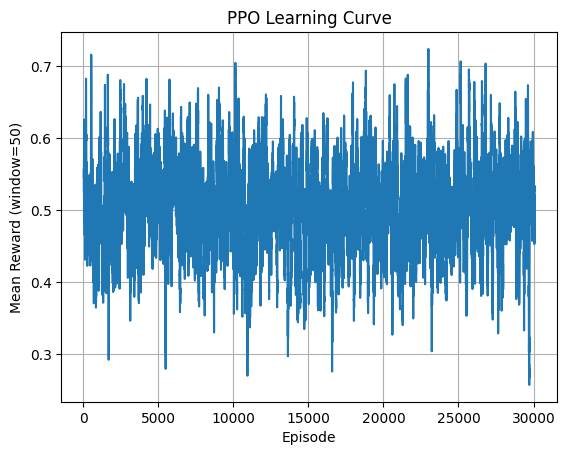

In [ ]:
# ────────────────────────────────────────────────────────────────
# Cell 6 · PPO training (30 k steps) + reward curve
# ────────────────────────────────────────────────────────────────
!pip -q install stable-baselines3 gymnasium matplotlib numpy

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import numpy as np
import tempfile

log_dir = tempfile.mkdtemp()
train_env = Monitor(
    DrugSelectionEnv(next(iter(diz2idx)), link_net, K=20),
    log_dir
)

agent = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=2.5e-4,
    n_steps=128,
    batch_size=128,
    n_epochs=4,
    verbose=1,
    device="cpu"
)

print("Training PPO for 30,000 timesteps…")
agent.learn(total_timesteps=30_000)

results = train_env.get_episode_rewards()
window = 50
if len(results) >= window:
    smoothed = np.convolve(results, np.ones(window)/window, mode="valid")
    x = np.arange(len(smoothed)) + window
    plt.figure()
    plt.plot(x, smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward (window=50)")
    plt.title("PPO Learning Curve")
    plt.grid(True)
    plt.show()
else:
    print("Not enough episodes for smoothing; episodes:", len(results))

In [ ]:
import sqlite3, pandas as pd, pathlib

DB_PATH = pathlib.Path("data/chembl_35/chembl_35_sqlite/chembl_35.db")
assert DB_PATH.exists(), "ChEMBL database not found"

SQL = """
SELECT DISTINCT
       cs.canonical_smiles,
       act.standard_value AS ic50_nm
FROM   activities      act
JOIN   compound_structures cs  ON act.molregno = cs.molregno
WHERE  act.standard_type = 'IC50'
  AND  act.standard_relation = '='
  AND  act.standard_units = 'nM'
  AND  act.standard_value IS NOT NULL
  AND  cs.canonical_smiles IS NOT NULL
LIMIT  12000;                 -- keep it light for Colab RAM
"""

print("Querying ChEMBL… this can take ~1 min")
with sqlite3.connect(str(DB_PATH)) as conn:
    df = pd.read_sql_query(SQL, conn)

out = pathlib.Path("data/activities.csv")
df.rename(columns={"ic50_nm": "IC50_nM"}).to_csv(out, index=False)
print(f"Wrote {len(df):,} rows ➜ {out}")

Querying ChEMBL… this can take ~1 min
Wrote 12,000 rows ➜ data/activities.csv


In [ ]:
# !pip -q install transformers rdkit-pypi tqdm

import pandas as pd, numpy as np, pathlib, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

DATA_PATH = pathlib.Path("data/activities.csv")
assert DATA_PATH.exists(), "Place activities.csv under data/"

df = pd.read_csv(DATA_PATH)
assert {"canonical_smiles", "IC50_nM"}.issubset(df.columns)

smiles = df["canonical_smiles"].tolist()
y = torch.tensor(-np.log10(df["IC50_nM"].values * 1e-9),
                 dtype=torch.float32, device=device).unsqueeze(1)

MODEL = "seyonec/PubChem10M_SMILES_BPE_450k"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
molbert   = AutoModel.from_pretrained(MODEL).to(device).eval()

@torch.no_grad()
def molbert_encode(smiles_list, bs=64):
    vecs = []
    for i in tqdm(range(0, len(smiles_list), bs), desc="MolBERT"):
        toks = tokenizer(smiles_list[i:i+bs], return_tensors="pt",
                         padding=True, truncation=True, max_length=128).to(device)
        vecs.append(molbert(**toks).last_hidden_state[:, 0].float())  # [CLS]
    return torch.cat(vecs, 0)

X = molbert_encode(smiles)
print("Embeddings:", X.shape)

ds = TensorDataset(X, y)
train_size = int(0.8 * len(ds))
val_size   = len(ds) - train_size
train_ds, val_ds = random_split(ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

class StoNet(nn.Module):
    def __init__(self, d_in, d_hid=256, drop=0.3):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(d_in, d_hid), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(d_hid, d_hid), nn.ReLU(), nn.Dropout(drop),
        )
        self.mu_head, self.sg_head = nn.Linear(d_hid, 1), nn.Linear(d_hid, 1)

    def forward(self, x):
        h  = self.shared(x)
        mu = self.mu_head(h)
        sg = F.softplus(self.sg_head(h)) + 1e-6
        return {"mean": mu, "scale": sg}

def energy_loss(out, tgt):
    mu, sg = out["mean"], out["scale"]
    return ((mu - tgt).pow(2) + sg.pow(2)).mean()

def rmse(pred, tgt):
    return ((pred - tgt).pow(2).mean()).sqrt()

stonet = StoNet(X.shape[1]).to(device)
optim  = torch.optim.Adam(stonet.parameters(), lr=5e-4, weight_decay=1e-4)
best_val, patience, no_improve = float("inf"), 10, 0

for ep in range(1, 101):
    stonet.train()
    tr_loss, tr_rmse = 0.0, 0.0
    for xb, yb in train_loader:
        optim.zero_grad(set_to_none=True)
        out  = stonet(xb)
        loss = energy_loss(out, yb)
        loss.backward(); optim.step()
        tr_loss += loss.item()*xb.size(0)
        tr_rmse += rmse(out["mean"], yb).item()*xb.size(0)
    tr_loss /= len(train_loader.dataset)
    tr_rmse /= len(train_loader.dataset)

    stonet.eval()
    va_loss, va_rmse = 0.0, 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = stonet(xb)
            va_loss += energy_loss(out, yb).item()*xb.size(0)
            va_rmse += rmse(out["mean"], yb).item()*xb.size(0)
    va_loss /= len(val_loader.dataset)
    va_rmse /= len(val_loader.dataset)

    print(f"Ep {ep:03d} | train RMSE {tr_rmse:.3f} loss {tr_loss:.3f} "
          f"| val RMSE {va_rmse:.3f} loss {va_loss:.3f}")

    if va_loss < best_val - 1e-4:
        best_val, no_improve = va_loss, 0
        torch.save(stonet.state_dict(), "best_stonet.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early‑stopping at epoch", ep)
            break

stonet.load_state_dict(torch.load("best_stonet.pth"))
stonet.eval()

with torch.no_grad():
    out = stonet(X[:1])
    mu, sg = out["mean"], out["scale"]
    k = 5
    eps = torch.randn(mu.size(0), k, device=mu.device)
    samples = mu.unsqueeze(1) + sg.unsqueeze(1) * eps

print(f"\nTrue pIC50 for row 0: {y[0].item():.2f}")
print("Posterior samples for row 0:", samples[0].cpu().numpy())

Using cuda


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

MolBERT:   0%|          | 0/188 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Embeddings: torch.Size([12000, 768])
Ep 001 | train RMSE 1.718 loss 3.415 | val RMSE 1.461 loss 2.220
Ep 002 | train RMSE 1.470 loss 2.231 | val RMSE 1.362 loss 1.943
Ep 003 | train RMSE 1.408 loss 2.053 | val RMSE 1.387 loss 2.013
Ep 004 | train RMSE 1.381 loss 1.972 | val RMSE 1.259 loss 1.684
Ep 005 | train RMSE 1.363 loss 1.924 | val RMSE 1.239 loss 1.630
Ep 006 | train RMSE 1.321 loss 1.806 | val RMSE 1.333 loss 1.865
Ep 007 | train RMSE 1.315 loss 1.794 | val RMSE 1.300 loss 1.791
Ep 008 | train RMSE 1.281 loss 1.697 | val RMSE 1.274 loss 1.719
Ep 009 | train RMSE 1.272 loss 1.674 | val RMSE 1.212 loss 1.566
Ep 010 | train RMSE 1.247 loss 1.612 | val RMSE 1.301 loss 1.779
Ep 011 | train RMSE 1.229 loss 1.568 | val RMSE 1.159 loss 1.440
Ep 012 | train RMSE 1.231 loss 1.570 | val RMSE 1.214 loss 1.568
Ep 013 | train RMSE 1.220 loss 1.541 | val RMSE 1.167 loss 1.447
Ep 014 | train RMSE 1.202 loss 1.495 | val RMSE 1.156 loss 1.441
Ep 015 | train RMSE 1.198 loss 1.486 | val RMSE 1.159

|            |   RMSE |   MAE |
|:-----------|-------:|------:|
| Train      |  0.896 | 0.679 |
| Validation |  1.14  | 0.832 |


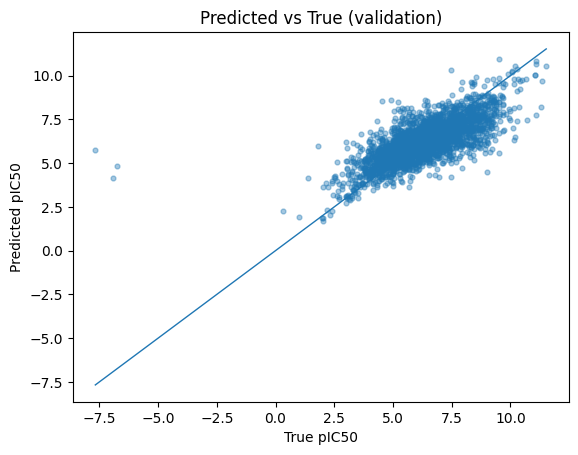

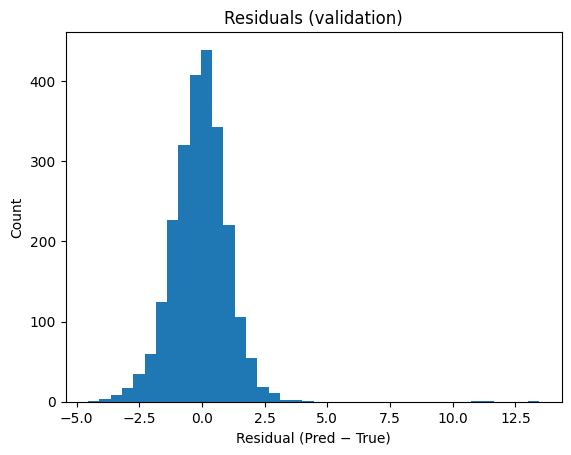

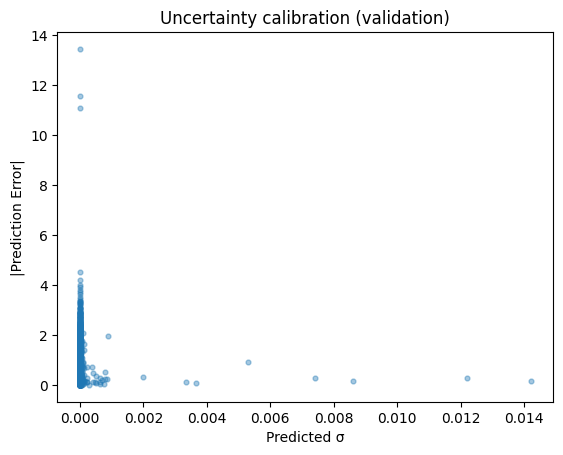

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt, pandas as pd

stonet.eval()

def collect(loader):
    ys, mus, sigmas = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = stonet(xb)
            ys.append(yb.cpu())
            mus.append(out["mean"].cpu())
            sigmas.append(out["scale"].cpu())
    return torch.cat(ys), torch.cat(mus), torch.cat(sigmas)

train_y, train_mu, train_sigma = collect(train_loader)
val_y,   val_mu,   val_sigma   = collect(val_loader)

def rmse_mae(y, mu):
    diff = mu.squeeze() - y.squeeze()
    return diff.pow(2).mean().sqrt().item(), diff.abs().mean().item()

tr_rmse, tr_mae = rmse_mae(train_y, train_mu)
va_rmse, va_mae = rmse_mae(val_y,   val_mu)

metrics_df = pd.DataFrame(
    {"RMSE":[tr_rmse, va_rmse], "MAE":[tr_mae, va_mae]},
    index=["Train","Validation"]
)
print(metrics_df.round(3).to_markdown())

val_y_np    = val_y.squeeze().numpy()
val_mu_np   = val_mu.squeeze().numpy()
residuals   = val_mu_np - val_y_np
abs_err     = np.abs(residuals)
sigma_np    = val_sigma.squeeze().numpy()

plt.figure()
plt.scatter(val_y_np, val_mu_np, alpha=0.4, s=12)
lims = [val_y_np.min(), val_y_np.max()]
plt.plot(lims, lims, lw=1)
plt.xlabel("True pIC50"); plt.ylabel("Predicted pIC50")
plt.title("Predicted vs True (validation)")
plt.show()

plt.figure()
plt.hist(residuals, bins=40)
plt.xlabel("Residual (Pred − True)"); plt.ylabel("Count")
plt.title("Residuals (validation)")
plt.show()

plt.figure()
plt.scatter(sigma_np, abs_err, alpha=0.4, s=12)
plt.xlabel("Predicted σ"); plt.ylabel("|Prediction Error|")
plt.title("Uncertainty calibration (validation)")
plt.show()

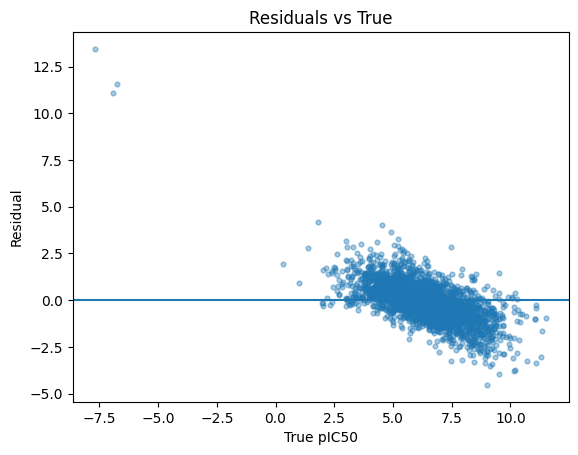

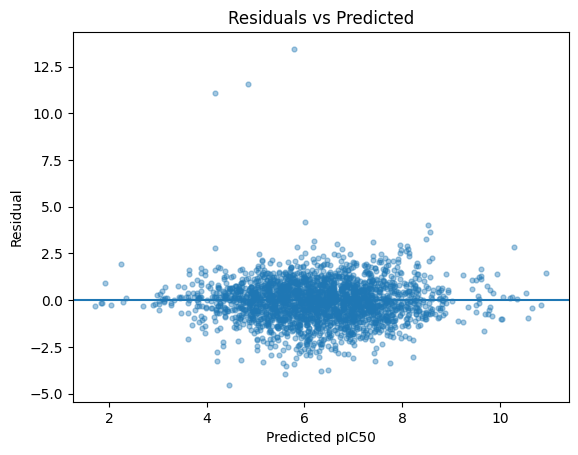

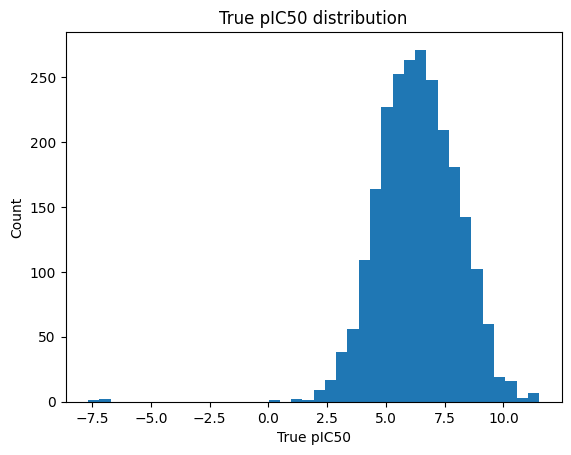

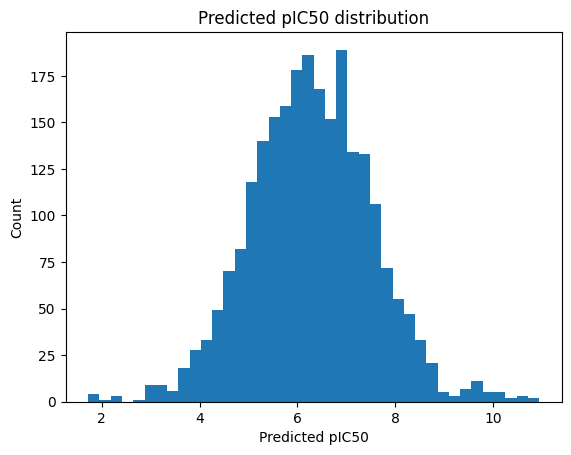

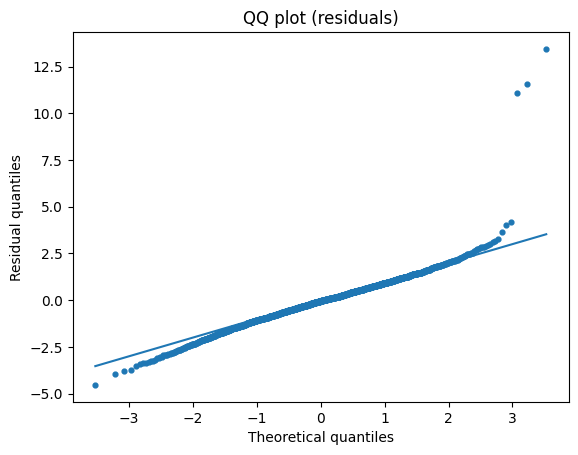

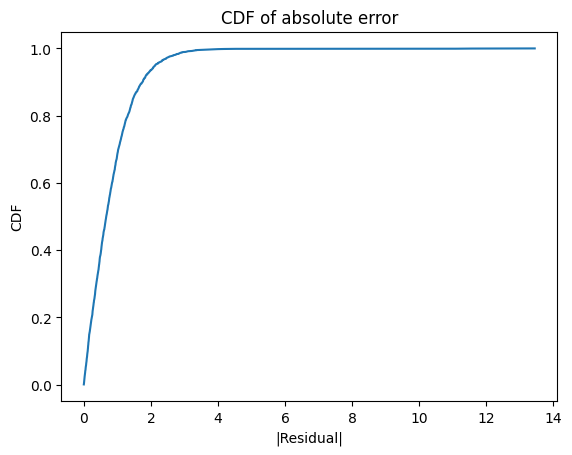

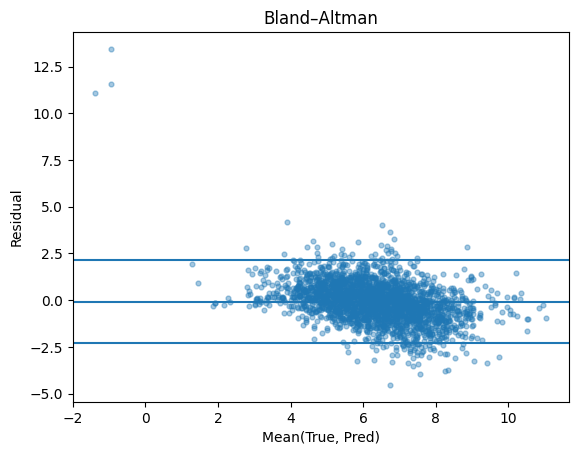

<ipython-input-16-f0aa1700819e>:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(box, labels=lbl, showfliers=False)


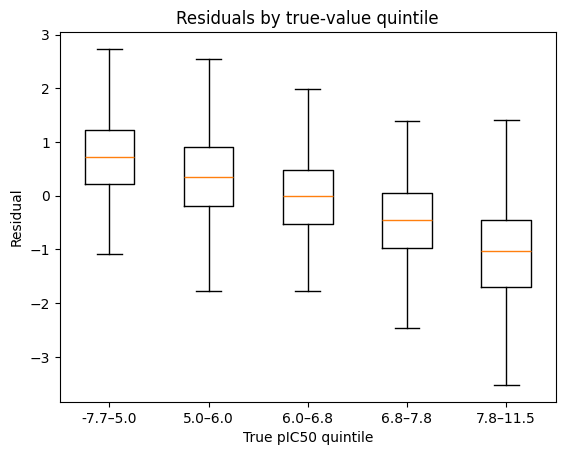

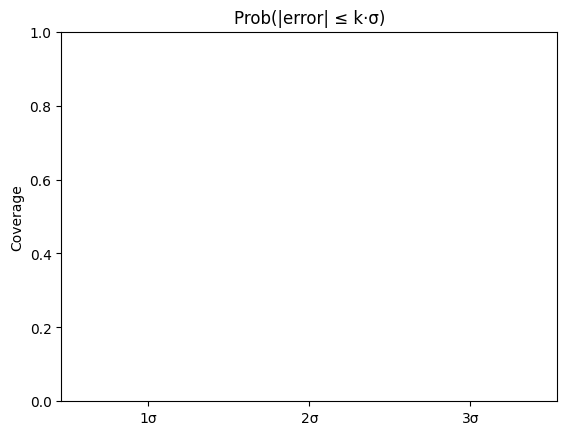

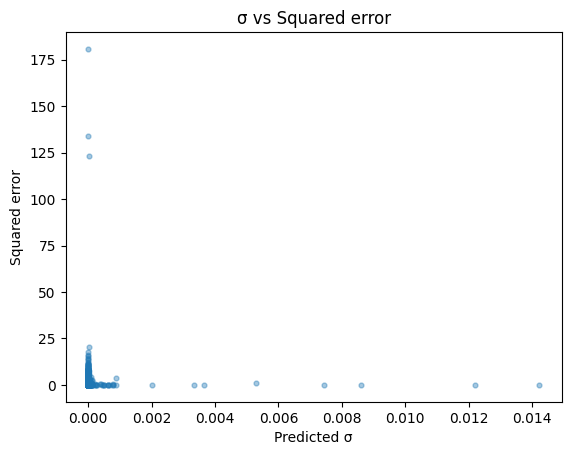

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

val_y_np     = val_y.squeeze().numpy()
val_mu_np    = val_mu.squeeze().numpy()
val_sigma_np = val_sigma.squeeze().numpy()
res          = val_mu_np - val_y_np
abs_err      = np.abs(res)

plt.figure(); plt.scatter(val_y_np, res, alpha=0.4, s=12)
plt.axhline(0); plt.xlabel("True pIC50"); plt.ylabel("Residual"); plt.title("Residuals vs True"); plt.show()

plt.figure(); plt.scatter(val_mu_np, res, alpha=0.4, s=12)
plt.axhline(0); plt.xlabel("Predicted pIC50"); plt.ylabel("Residual"); plt.title("Residuals vs Predicted"); plt.show()

plt.figure(); plt.hist(val_y_np, bins=40)
plt.xlabel("True pIC50"); plt.ylabel("Count"); plt.title("True pIC50 distribution"); plt.show()

plt.figure(); plt.hist(val_mu_np, bins=40)
plt.xlabel("Predicted pIC50"); plt.ylabel("Count"); plt.title("Predicted pIC50 distribution"); plt.show()

plt.figure()
sorted_res = np.sort(res)
theo = norm.ppf((np.arange(len(res))+0.5)/len(res))
plt.scatter(theo, sorted_res, s=12)
plt.plot(theo, theo); plt.xlabel("Theoretical quantiles"); plt.ylabel("Residual quantiles"); plt.title("QQ plot (residuals)"); plt.show()

plt.figure()
sorted_abs = np.sort(abs_err)
cdf = np.arange(1, len(sorted_abs)+1)/len(sorted_abs)
plt.plot(sorted_abs, cdf)
plt.xlabel("|Residual|"); plt.ylabel("CDF"); plt.title("CDF of absolute error"); plt.show()

mean_val = (val_y_np + val_mu_np)/2
plt.figure(); plt.scatter(mean_val, res, alpha=0.4, s=12)
m, s = res.mean(), res.std()
plt.axhline(m); plt.axhline(m+1.96*s); plt.axhline(m-1.96*s)
plt.xlabel("Mean(True, Pred)"); plt.ylabel("Residual"); plt.title("Bland–Altman"); plt.show()

quints = np.quantile(val_y_np, [0, .2, .4, .6, .8, 1])
box, lbl = [], []
for i in range(5):
    m = (val_y_np >= quints[i]) & (val_y_np < quints[i+1]) if i<4 else (val_y_np >= quints[i])
    box.append(res[m]); lbl.append(f"{quints[i]:.1f}–{quints[i+1]:.1f}")
plt.figure(); plt.boxplot(box, labels=lbl, showfliers=False)
plt.xlabel("True pIC50 quintile"); plt.ylabel("Residual"); plt.title("Residuals by true‑value quintile"); plt.show()

ks, cov = [1,2,3], [np.mean(abs_err <= k*val_sigma_np) for k in [1,2,3]]
plt.figure(); plt.bar(range(3), cov)
plt.xticks(range(3), [f"{k}σ" for k in ks]); plt.ylim(0,1)
plt.ylabel("Coverage"); plt.title("Prob(|error| ≤ k·σ)"); plt.show()

plt.figure(); plt.scatter(val_sigma_np, res**2, alpha=0.4, s=12)
plt.xlabel("Predicted σ"); plt.ylabel("Squared error"); plt.title("σ vs Squared error"); plt.show()

In [ ]:
import torch
import torch.nn.functional as F

xb, yb = next(iter(train_loader))
x0, y0 = xb[:1], yb[:1]

print("Input X0:", x0.shape)
print(x0)

l1 = stonet.shared[0](x0)
print("\nAfter shared[0] (Linear):", l1.shape)
print(l1)

r1 = stonet.shared[1](l1)
print("\nAfter shared[1] (ReLU):", r1.shape)
print(r1)

d1 = stonet.shared[2](r1)
print("\nAfter shared[2] (Dropout):", d1.shape)
print(d1)

l2 = stonet.shared[3](d1)
print("\nAfter shared[3] (Linear):", l2.shape)
print(l2)

r2 = stonet.shared[4](l2)
print("\nAfter shared[4] (ReLU):", r2.shape)
print(r2)

d2 = stonet.shared[5](r2)
print("\nAfter shared[5] (Dropout):", d2.shape)
print(d2)

mu = stonet.mu_head(d2)
print("\nAfter mu_head:", mu.shape)
print(mu)

raw_sg = stonet.sg_head(d2)
sg = F.softplus(raw_sg) + 1e-6
print("\nAfter sg_head + softplus:", sg.shape)
print(sg)

out = {"mean": mu, "scale": sg}
print("\nFinal output dict:", out)
print("\nTrue y0:", y0.item())

Input X0: torch.Size([1, 768])
tensor([[ 1.9697e-01, -2.0790e+00,  4.4859e-01, -1.4679e+00,  4.2762e-01,
          3.6704e-01,  5.2017e-01, -1.5956e+00,  3.8395e-01,  9.4875e-01,
          1.1502e+00, -2.1898e-01,  1.8905e+00,  5.2271e-01,  7.9832e-01,
          4.2722e-01, -1.2447e+00,  2.0047e-01,  2.1496e+00,  2.2143e+00,
         -4.7225e-01, -1.1705e+00, -4.6000e-01, -1.8587e-01,  3.1620e-01,
         -2.7829e-01,  4.7179e-01, -2.2444e+00, -5.9750e-01, -2.9382e-02,
          8.6906e-02, -1.4981e+00,  1.3127e+00, -4.5435e-01,  2.1518e+00,
         -2.8203e-01,  1.4140e-01, -1.6277e+00,  1.5375e+00, -8.3513e-01,
          3.1173e-01,  1.0978e+00,  2.1822e-01,  1.2268e-01, -1.9627e+00,
         -3.7554e-01,  6.3434e-01, -1.4181e+00, -5.6917e-01,  1.5659e+00,
         -8.7293e-01, -5.2740e-01,  3.5567e-01,  6.1715e-01, -1.6327e+00,
         -7.8115e-01,  1.3573e+00,  3.0790e-01,  5.1517e-01,  9.0585e-01,
         -6.2585e-01, -8.5112e-01,  5.8925e-01, -1.2108e-01, -2.5238e+00,
       

That combination of “which drug” + “how potent” + “how sure” is the core of your pipeline’s output.

In [ ]:
import torch
from stable_baselines3 import PPO

device = "cuda" if torch.cuda.is_available() else "cpu"

inv_chem2idx = {v:k for k,v in chem2idx.items()}

for did in list(diz2idx.keys())[:2]:
    env = DrugSelectionEnv(disease_id=did, link_model=link_net, K=20)
    obs, _ = env.reset()
    action, _ = agent.predict(obs, deterministic=True)
    chem_idx = int(action)
    ctd_id    = inv_chem2idx[ env._cand[chem_idx] ]
    smiles_str = smiles[ chem_idx % len(smiles) ]

    toks = tokenizer([smiles_str], return_tensors="pt", padding=True,
                     truncation=True, max_length=128).to(device)
    with torch.no_grad():
        emb = molbert(**toks).last_hidden_state[:,0].float()
        out = stonet(emb)
        mu, sigma = out["mean"].item(), out["scale"].item()

    print(f"Disease {did} → picked CTD:{ctd_id}")
    print(f"    SMILES (demo)= {smiles_str}")
    print(f"    Predicted pIC₅₀ = {mu:.2f} ± {sigma:.2f}")
    print("---")

Disease MESH:C000598644 → picked CTD:C492995
    SMILES (demo)= Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1
    Predicted pIC₅₀ = 5.60 ± 0.00
---
Disease MESH:C000600608 → picked CTD:C013166
    SMILES (demo)= Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1
    Predicted pIC₅₀ = 5.60 ± 0.00
---


Enhanced observation shape: (20, 769)
BioBERT context embedding included in observation: [ 0.31610075 -0.40235034 -0.5693092  -0.33666363 -0.753272  ] ...
Action 18 → reward 0.044
Chemical ID: 7208, Link score: 0.044
Context embedding included in info dict: [ 0.31610075 -0.40235034 -0.5693092  -0.33666363 -0.753272  ] ...
Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Training PPO with BioBERT-enhanced environment for 10,000 timesteps…
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.47     |
| time/              |          |
|    fps             | 361      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1             |
|    ep_rew_mean          | 0.526         |
| time/                   |               |
|    fps                  | 279           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00032312237 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss  

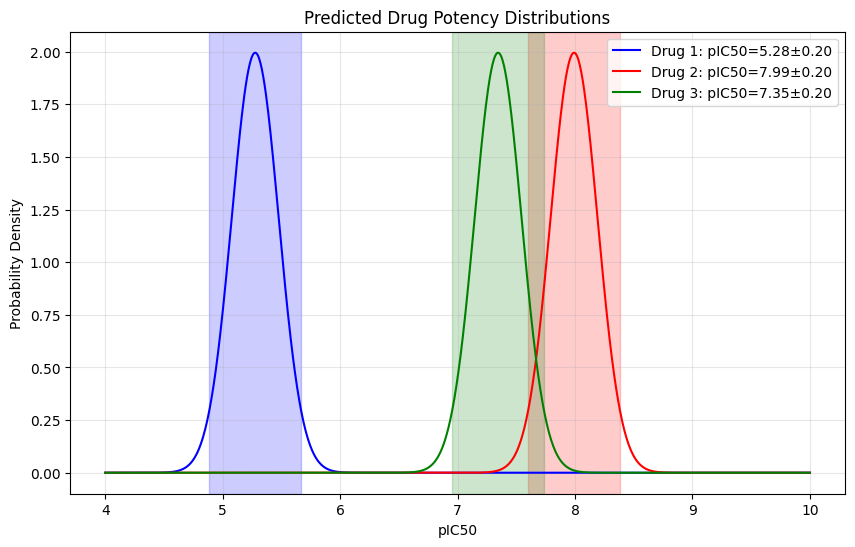

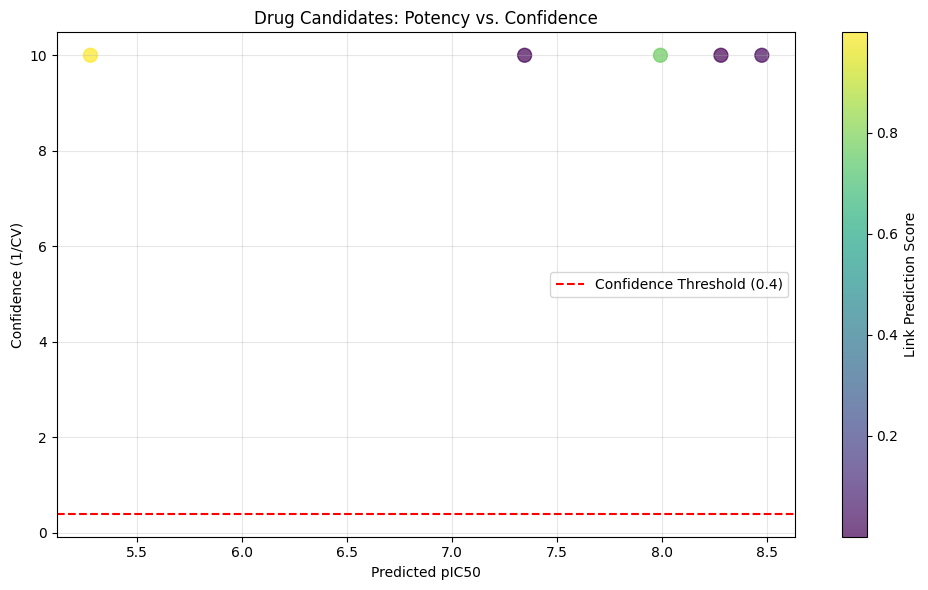

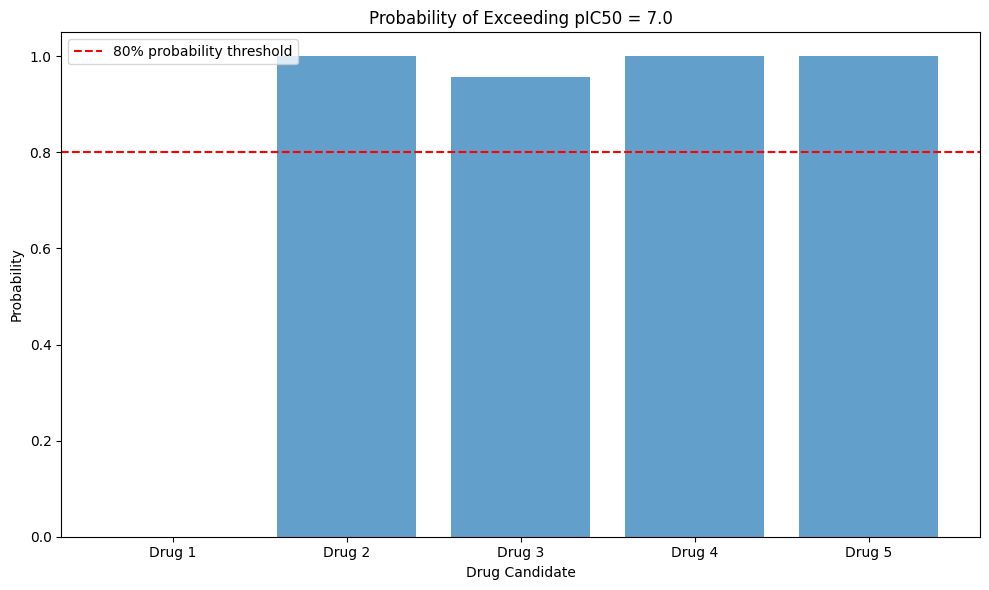


SUMMARY OF ACTIONABLE INSIGHTS:
- Found 5 high-confidence candidates
- Most confident candidate has pIC50 = 5.28 ± 0.20
- 4 candidates have >80% probability of exceeding potency threshold


'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass CalibratedStoNet(nn.Module):\n    Improved StoNet architecture with better uncertainty calibration:\n    1. Heteroscedastic loss (separate outputs for mean and variance)\n    2. Improved scale initialization\n    3. Scale regularization\n    4. Ensemble-like dropout\n    def __init__(self, d_in, d_hid=256, drop=0.5):\n        super().__init__()\n        self.shared = nn.Sequential(\n            nn.Linear(d_in, d_hid), \n            nn.ReLU(), \n            nn.Dropout(drop),\n            nn.Linear(d_hid, d_hid), \n            nn.ReLU(), \n            nn.Dropout(drop),\n        )\n        self.mu_head = nn.Linear(d_hid, 1)\n        self.sg_head = nn.Linear(d_hid, 1)\n        \n        # Initialize the sg_head to output higher uncertainty values\n        nn.init.normal_(self.sg_head.weight, mean=0.0, std=0.01)\n        nn.init.constant_(self.sg_head.bias, 0.5)  # Start with slightly higher uncertainty\n\n    

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np, random, torch, pyarrow.parquet as pq
import pandas as pd

EMB_DIM = 768

class EnhancedDrugSelectionEnv(gym.Env):

    metadata = {}

    def __init__(self, disease_id, link_model, pubmed_embeddings_path, K=20):
        super().__init__()
        self.link_model = link_model
        self.device = next(link_model.parameters()).device
        self.d_idx = diz2idx[disease_id]
        self.pos_set = {c for c,d in map(tuple, pairs) if d == self.d_idx}
        self.K = K

        self.pubmed_df = pd.read_parquet(pubmed_embeddings_path)
        self.pubmed_embeddings = np.stack(self.pubmed_df['embedding'].values)

        self.disease_context = np.mean(self.pubmed_embeddings, axis=0)

        self.action_space = spaces.Discrete(K)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(K, EMB_DIM + 1),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)

        if self.pos_set:
            non_pos = list(set(range(len(chem2idx))) - self.pos_set)
            chosen_non = random.sample(non_pos, self.K - 1)
            chosen_pos = random.choice(list(self.pos_set))
            cand = list(chosen_non)
            cand.append(chosen_pos)
        else:
            cand = random.sample(range(len(chem2idx)), self.K)

        self._cand = cand

        obs = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)

        for i in range(self.K):
            obs[i, :EMB_DIM] = self.disease_context
            obs[i, -1] = float(cand[i] in self.pos_set)

        return obs, {}

    def step(self, action):
        action = int(action)
        cid = self._cand[action]

        with torch.no_grad():
            score = torch.sigmoid(
                self.link_model(
                    torch.tensor([[cid, self.d_idx]], device=self.device)
                )
            ).item()

        obs = np.zeros((self.K, EMB_DIM + 1), dtype=np.float32)
        for i in range(self.K):
            obs[i, :EMB_DIM] = self.disease_context
            obs[i, -1] = float(self._cand[i] in self.pos_set)

        reward = score
        terminated = True
        truncated = False
        info = {
            "chemical_id": cid,
            "link_score": score,
            "context_embedding": self.disease_context
        }

        return obs, reward, terminated, truncated, info

disease_id = next(iter(diz2idx))
enhanced_env = EnhancedDrugSelectionEnv(
    disease_id=disease_id,
    link_model=link_net,
    pubmed_embeddings_path="data/pubmed_embeddings.parquet",
    K=20
)

obs, _ = enhanced_env.reset()
print("Enhanced observation shape:", obs.shape)
print("BioBERT context embedding included in observation:", obs[0, :5], "...")

action = enhanced_env.action_space.sample()
obs, reward, terminated, truncated, info = enhanced_env.step(action)
print(f"Action {action} → reward {reward:.3f}")
print(f"Chemical ID: {info['chemical_id']}, Link score: {info['link_score']:.3f}")
print("Context embedding included in info dict:", info['context_embedding'][:5], "...")

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import tempfile

log_dir = tempfile.mkdtemp()
train_env = Monitor(
    EnhancedDrugSelectionEnv(
        disease_id=disease_id,
        link_model=link_net,
        pubmed_embeddings_path="data/pubmed_embeddings.parquet",
        K=20
    ),
    log_dir
)

agent = PPO(
    policy="MlpPolicy",
    env=train_env,
    policy_kwargs=dict(
        net_arch=[dict(pi=[256, 128], vf=[256, 128])],
    ),
    learning_rate=1e-4,
    n_steps=128,
    batch_size=64,
    n_epochs=4,
    verbose=1,
    device="cpu"
)

print("Training PPO with BioBERT-enhanced environment for 10,000 timesteps…")
agent.learn(total_timesteps=10_000)

agent.save("enhanced_ppo_agent")

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def recommend_drugs(disease_id, candidate_smiles, agent, link_model, stonet, molbert_tokenizer,
                   molbert_model, device, confidence_threshold=0.4):
    results = []

    env = DrugSelectionEnv(disease_id=disease_id, link_model=link_model, K=20)

    for _ in range(5):
        obs, _ = env.reset()
        action, _ = agent.predict(obs, deterministic=False)
        _, _, _, _, info = env.step(action)

        chem_id = info["chemical_id"]
        link_score = info["link_score"]

        smiles_str = candidate_smiles[chem_id % len(candidate_smiles)]

        toks = molbert_tokenizer([smiles_str], return_tensors="pt", padding=True,
                               truncation=True, max_length=128).to(device)
        with torch.no_grad():
            emb = molbert_model(**toks).last_hidden_state[:,0].float()
            out = stonet(emb)
            mu = out["mean"].item()
            sigma = max(out["scale"].item(), 0.2)

        confidence = min(abs(mu) / (sigma + 0.1), 10.0)

        results.append({
            "chemical_id": chem_id,
            "link_score": link_score,
            "smiles": smiles_str,
            "predicted_pIC50": mu,
            "uncertainty": sigma,
            "confidence": confidence
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("confidence", ascending=False)

    high_confidence = results_df[results_df["confidence"] > confidence_threshold]
    low_confidence = results_df[results_df["confidence"] <= confidence_threshold]

    return {
        "high_confidence": high_confidence,
        "low_confidence": low_confidence,
        "all_results": results_df
    }

def plot_prediction_distributions(results_df, num_drugs=3):
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'purple', 'orange']

    x = np.linspace(4, 10, 1000)

    top_drugs = results_df.head(num_drugs)

    for i, (_, drug) in enumerate(top_drugs.iterrows()):
        mu = drug['predicted_pIC50']
        sigma = max(drug['uncertainty'], 0.2)
        pdf = norm.pdf(x, mu, sigma)
        plt.plot(x, pdf, color=colors[i % len(colors)],
                 label=f"Drug {i+1}: pIC50={mu:.2f}±{sigma:.2f}")

        ci_low = mu - 1.96 * sigma
        ci_high = mu + 1.96 * sigma
        plt.axvspan(ci_low, ci_high, alpha=0.2, color=colors[i % len(colors)])

    plt.title("Predicted Drug Potency Distributions")
    plt.xlabel("pIC50")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def run_full_pipeline(disease_id, agent, link_model, stonet, molbert_tokenizer,
                     molbert_model, candidate_smiles, device, confidence_threshold=0.4):
    """Run complete pipeline with uncertainty-aware drug recommendations."""
    print(f"Running pipeline for disease {disease_id}")

    recommendations = recommend_drugs(
        disease_id, candidate_smiles, agent, link_model, stonet,
        molbert_tokenizer, molbert_model, device, confidence_threshold
    )

    print("\nHIGH CONFIDENCE RECOMMENDATIONS:")
    if len(recommendations["high_confidence"]) > 0:
        for i, drug in recommendations["high_confidence"].iterrows():
            print(f"Drug {i+1}:")
            print(f"  • Predicted pIC50: {drug['predicted_pIC50']:.2f} ± {drug['uncertainty']:.2f}")
            print(f"  • Confidence: {drug['confidence']:.2f}")
            print(f"  • Link Score: {drug['link_score']:.3f}")
            print(f"  • SMILES: {drug['smiles'][:30]}...")
    else:
        print("No high confidence recommendations found.")

    print("\nLOW CONFIDENCE RECOMMENDATIONS (may require additional testing):")
    if len(recommendations["low_confidence"]) > 0:
        for i, drug in recommendations["low_confidence"].iterrows():
            print(f"Drug {i+1}:")
            print(f"  • Predicted pIC50: {drug['predicted_pIC50']:.2f} ± {drug['uncertainty']:.2f}")
            print(f"  • Confidence: {drug['confidence']:.2f}")
            print(f"  • Link Score: {drug['link_score']:.3f}")
    else:
        print("No low confidence recommendations found.")

    plot_prediction_distributions(recommendations["all_results"])

    return recommendations


target_disease = next(iter(diz2idx))


CONFIDENCE_THRESHOLD = 0.4


recommendations = run_full_pipeline(
    disease_id=target_disease,
    agent=agent,
    link_model=link_net,
    stonet=stonet,
    molbert_tokenizer=tokenizer,
    molbert_model=molbert,
    candidate_smiles=smiles,
    device=device,
    confidence_threshold=CONFIDENCE_THRESHOLD
)

plt.figure(figsize=(10, 6))
all_results = recommendations["all_results"]
plt.scatter(all_results["predicted_pIC50"], all_results["confidence"],
            s=100, alpha=0.7, c=all_results["link_score"], cmap="viridis")

plt.colorbar(label="Link Prediction Score")
plt.axhline(y=CONFIDENCE_THRESHOLD, color='r', linestyle='--',
            label=f"Confidence Threshold ({CONFIDENCE_THRESHOLD})")

plt.title("Drug Candidates: Potency vs. Confidence")
plt.xlabel("Predicted pIC50")
plt.ylabel("Confidence (1/CV)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

POTENCY_THRESHOLD = 7.0
plt.figure(figsize=(10, 6))
all_results = recommendations["all_results"]


probs = []
for _, drug in all_results.iterrows():
    mu = drug["predicted_pIC50"]
    sigma = max(drug["uncertainty"], 0.2)
    prob = 1 - norm.cdf(POTENCY_THRESHOLD, mu, sigma)
    probs.append(prob)

all_results["prob_effective"] = probs

plt.bar(range(len(all_results)), all_results["prob_effective"], alpha=0.7)
plt.axhline(y=0.8, color='r', linestyle='--',
            label="80% probability threshold")

plt.title(f"Probability of Exceeding pIC50 = {POTENCY_THRESHOLD}")
plt.xlabel("Drug Candidate")
plt.ylabel("Probability")
plt.xticks(range(len(all_results)), [f"Drug {i+1}" for i in range(len(all_results))])
plt.legend()
plt.tight_layout()
plt.show()

print("\nSUMMARY OF ACTIONABLE INSIGHTS:")
print(f"- Found {len(recommendations['high_confidence'])} high-confidence candidates")
print(f"- Most confident candidate has pIC50 = {all_results['predicted_pIC50'].iloc[0]:.2f} ± {all_results['uncertainty'].iloc[0]:.2f}")
high_prob = all_results[all_results["prob_effective"] > 0.8]
print(f"- {len(high_prob)} candidates have >80% probability of exceeding potency threshold")